In [1]:
import os
import sys
sys.path.append('..')

from IPython.display import clear_output

import glob
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
np.seterr(divide='ignore', invalid='ignore')

from uncertain.implicit import logMF, CAMF
from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP, ABPR, GPR
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from uncertain.utils.data import ImplicitData as Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('Behance')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('Behance_appreciate_1M', sep=' ', header=None)
    data.columns = ['user', 'item', 'timestamps']
    data = Data(data, users_on_val_test=5000)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)
        
base_conf = {'embedding_dim':1, 'lr':0, 'weight_decay':0}
trials = 20 # Train mode
# trials = 0 # Eval mode

Data prepared: 23971 users, 32489 items.
643444 train, 27894 validation and 26782 test interactions.


In [18]:
2**14, 2**18, 1e-4, 1e-2

(16384, 262144, 0.0001, 0.01)

# BPR

In [2]:
name = 'BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**14, 2**18)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-7, 1e-5)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.9014636696288552, 'Rating_rec': {'MAP': array([0.0484    , 0.0654    , 0.07341667, 0.07784444, 0.08110944,
       0.08362839, 0.08525589, 0.08619354, 0.08707145, 0.08773972]), 'Recall': array([0.01657521, 0.03077292, 0.04113957, 0.04856911, 0.05543677,
       0.06436682, 0.07020215, 0.07585235, 0.08058586, 0.08443896])}}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
17,17,0.087730,2022-05-15 22:43:53.788091,2022-05-15 22:52:38.593501,0 days 00:08:44.805410,16457,200,0.001106,1.522170e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
13,13,0.086121,2022-05-15 22:18:23.343409,2022-05-15 22:26:57.895853,0 days 00:08:34.552444,59439,200,0.003104,1.679457e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
24,24,0.085500,2022-05-15 23:34:37.676524,2022-05-15 23:40:44.146230,0 days 00:06:06.469706,28020,200,0.003895,1.113138e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
11,11,0.084810,2022-05-15 22:07:33.905209,2022-05-15 22:14:06.862614,0 days 00:06:32.957405,20882,200,0.007066,2.619680e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
22,22,0.084665,2022-05-15 23:23:55.517771,2022-05-15 23:28:58.024886,0 days 00:05:02.507115,34447,200,0.006703,2.935684e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# Item support

In [3]:
results_isup = test(ItemHeuristic(base_MF=model, uncertainty=1/data.item_support), data, max_k=10, name='NEG-ITEM-SUPPORT')
clear_output(wait=True)
results_isup

{'FCP': 0.9014636696288552,
 'Concordant uncertainty': 0.048197803295030234,
 'Discordant uncertainty': 0.12381802048312138,
 'corr_usup': 0.0016152699156888072,
 'corr_isup': -1.0,
 'Rating_rec': {'MAP': array([0.0484    , 0.0654    , 0.07341667, 0.07784444, 0.08110944,
         0.08362839, 0.08525589, 0.08619354, 0.08707145, 0.08773972]),
  'Recall': array([0.01657521, 0.03077292, 0.04113957, 0.04856911, 0.05543677,
         0.06436682, 0.07020215, 0.07585235, 0.08058586, 0.08443896]),
  'Unc_MAP_corr': 0.10905620795790825,
  'URI': -0.22156380887555543},
 'Cuts': {'Values': array([0.2       , 0.14285714, 0.1       , 0.05263158]),
  'Coverage': array([1., 1., 1., 1., 1.]),
  'Relevance': array([4.82204706, 4.82080437, 4.8189501 , 4.81500361, 4.80264038]),
  'MAP': array([0.08773972, 0.0864117 , 0.08499456, 0.08420283, 0.08107367]),
  'Map*': array([0.08773972, 0.0864117 , 0.08499456, 0.08420283, 0.08107367])}}

# Ensemble / Resample

In [ ]:
best_params = study.best_params
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}

if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble', name=f'{i}')
models = [init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])]
for file in os.listdir('checkpoints/ensemble'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
results_ensemble = test(ensemble, data, name='ENSEMBLE', max_k=10)
clear_output(wait=True)

if trials > 0:
    og = deepcopy(data.train)
    for i in range(5):
        data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
        model = init_model(**best_params)
        train(model, data, path='checkpoints/resample', name=f'{i}')
    data.train = og
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model('bprMF', **best_params))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0]), models)
results_resample = test(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_ensemble, results_resample

# Linear-GPR

In [4]:
name = 'Linear-GPR'
def init_model(**kwargs):
    return biasMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**14, 2**18)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-7, 1e-5)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8887312373982525, 'Concordant uncertainty': 0.09265749, 'Discordant uncertainty': 0.10549963, 'corr_usup': -0.7914317247870313, 'corr_isup': -0.3570225799522458, 'Rating_rec': {'MAP': array([0.052     , 0.0672    , 0.07685   , 0.08161667, 0.08447611,
       0.08687167, 0.08797658, 0.08902383, 0.08982061, 0.08999865]), 'Recall': array([0.01907177, 0.02988786, 0.04049416, 0.04913388, 0.05573536,
       0.06252875, 0.06834943, 0.07382772, 0.07873761, 0.08260458]), 'Unc_MAP_corr': -0.1986041124051592, 'URI': -0.14945430552988578}, 'Cuts': {'Values': array([0.29530094, 0.2474623 , 0.19822665, 0.1395799 ]), 'Coverage': array([1.     , 1.     , 1.     , 1.     , 0.99992]), 'Relevance': array([1.52119758, 1.52093434, 1.51926117, 1.51538204, 1.48622032]), 'MAP': array([0.08999865, 0.08971619, 0.0876865 , 0.08579412, 0.07820079]), 'Map*': array([0.08999865, 0.08971619, 0.0876865 , 0.08579412, 0.07821643])}, 'Uncertain_rec': {'MAP': array([0.0418    , 0.0578    , 0.06465   , 0.06901111,

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
23,23,0.091286,2022-05-16 01:33:57.205980,2022-05-16 01:42:27.911789,0 days 00:08:30.705809,131562,200,0.008399,0.000001,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
20,20,0.084305,2022-05-16 00:59:22.757975,2022-05-16 01:10:54.556168,0 days 00:11:31.798193,190776,200,0.008105,0.000002,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
5,5,0.080560,2022-05-15 23:42:05.554933,2022-05-15 23:50:08.832712,0 days 00:08:03.277779,146636,200,0.009757,0.000002,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
2,2,0.078558,2022-05-15 17:37:24.035112,2022-05-15 17:44:34.884575,0 days 00:07:10.849463,50612,200,0.006937,0.000002,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
24,24,0.077110,2022-05-16 01:42:27.912586,2022-05-16 01:47:19.591047,0 days 00:04:51.678461,128903,200,0.009048,0.000001,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# FunkSVD-GPR

In [5]:
name = 'FunkSVD-GPR'
def init_model(**kwargs):
    return TwoWayMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**14, 2**18)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-7, 1e-5)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8898887312373982, 'Concordant uncertainty': 0.13672377, 'Discordant uncertainty': 0.15104116, 'corr_usup': -0.8546640429279241, 'corr_isup': -0.2782898583130807, 'Rating_rec': {'MAP': array([0.0494    , 0.0639    , 0.07236667, 0.07684444, 0.07972278,
       0.08209361, 0.08452738, 0.08532121, 0.08590352, 0.0868085 ]), 'Recall': array([0.01654594, 0.02774054, 0.03751154, 0.04651138, 0.05447204,
       0.0613878 , 0.06956651, 0.07453816, 0.07956739, 0.08530875]), 'Unc_MAP_corr': -0.20574347756110714, 'URI': -0.21182124232829672}, 'Cuts': {'Values': array([0.46051912, 0.39665413, 0.32356521, 0.2254251 ]), 'Coverage': array([1.     , 0.9999 , 0.9907 , 0.93322, 0.70644]), 'Relevance': array([1.83859066, 1.83584415, 1.81648717, 1.71602847, 1.34254697]), 'MAP': array([0.0868085 , 0.08501024, 0.08204334, 0.07570461, 0.06149707]), 'Map*': array([0.0868085 , 0.08502725, 0.08297263, 0.08160672, 0.08852082])}, 'Uncertain_rec': {'MAP': array([0.0364    , 0.052     , 0.05926667, 0.06374444

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
19,19,0.086149,2022-05-16 02:51:51.561926,2022-05-16 03:01:25.806421,0 days 00:09:34.244495,79902,200,0.006295,1.041325e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
22,22,0.084891,2022-05-16 03:09:22.120118,2022-05-16 03:20:56.284948,0 days 00:11:34.164830,138250,200,0.006355,9.769061e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
27,27,0.082855,2022-05-16 03:40:38.694581,2022-05-16 03:51:27.514020,0 days 00:10:48.819439,78460,200,0.005563,4.836015e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
12,12,0.081513,2022-05-16 01:57:35.943927,2022-05-16 02:09:18.539101,0 days 00:11:42.595174,80946,200,0.002851,1.068455e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
14,14,0.080240,2022-05-16 02:17:35.810257,2022-05-16 02:24:16.722236,0 days 00:06:40.911979,18604,200,0.006394,1.426428e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# GMF-GPR

In [6]:
name = 'GMF-GPR'
def init_model(**kwargs):
    return bprGMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**14, 2**18)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'weight_decay': trial.suggest_float('wd', 1e-7, 1e-5)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8789112090209843, 'Concordant uncertainty': 0.28246272, 'Discordant uncertainty': 0.6523247, 'corr_usup': -0.02083418401681658, 'corr_isup': -0.19102820611035706, 'Rating_rec': {'MAP': array([0.0342    , 0.0459    , 0.05201667, 0.05578333, 0.05903694,
       0.06135089, 0.0625154 , 0.06378659, 0.06420921, 0.06448482]), 'Recall': array([0.01146747, 0.01908471, 0.02453011, 0.03050708, 0.03682805,
       0.04256297, 0.04681247, 0.052522  , 0.05594577, 0.06024185]), 'Unc_MAP_corr': -0.23126275351975092, 'URI': 0.2668432654383066}, 'Cuts': {'Values': array([0.79244651, 0.7106361 , 0.64416317, 0.55875013]), 'Coverage': array([1., 1., 1., 1., 1.]), 'Relevance': array([3.55768369, 3.55768369, 3.55768369, 3.55768369, 3.55768369]), 'MAP': array([0.06448482, 0.06448482, 0.06448482, 0.06448482, 0.06448482]), 'Map*': array([0.06448482, 0.06448482, 0.06448482, 0.06448482, 0.06448482])}, 'Uncertain_rec': {'MAP': array([0.0342    , 0.0456    , 0.05218333, 0.05591667, 0.05909028,
       0.061

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
16,16,0.066276,2022-05-16 04:54:53.523498,2022-05-16 04:58:24.703797,0 days 00:03:31.180299,66492,200,0.007106,1.374362e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
14,14,0.064605,2022-05-16 04:44:44.225297,2022-05-16 04:51:17.636617,0 days 00:06:33.411320,127651,200,0.007681,9.757954e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
9,9,0.062672,2022-05-16 04:17:07.664465,2022-05-16 04:28:49.228275,0 days 00:11:41.563810,74891,200,0.001175,1.244642e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
7,7,0.062173,2022-05-16 04:09:26.361303,2022-05-16 04:12:51.862892,0 days 00:03:25.501589,116131,200,0.009335,2.811101e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
21,21,0.062043,2022-05-16 05:17:13.275315,2022-05-16 05:20:24.592495,0 days 00:03:11.317180,71842,200,0.007102,1.134292e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
19,19,0.061998,2022-05-16 05:09:47.959771,2022-05-16 05:13:22.885230,0 days 00:03:34.925459,67115,200,0.008410,1.434148e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
22,22,0.061232,2022-05-16 05:20:24.593469,2022-05-16 05:22:59.583990,0 days 00:02:34.990521,81556,200,0.008608,1.731258e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
11,11,0.061223,2022-05-16 04:32:19.220805,2022-05-16 04:35:34.771380,0 days 00:03:15.550575,99450,200,0.009558,2.628093e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
12,12,0.060867,2022-05-16 04:35:34.772328,2022-05-16 04:38:33.434075,0 days 00:02:58.661747,102656,200,0.009446,2.322458e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE
18,18,0.058495,2022-05-16 05:03:27.609965,2022-05-16 05:09:47.959028,0 days 00:06:20.349063,126785,200,0.006638,3.813337e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Beha...,COMPLETE


# Results

                       FCP  Concordant uncertainty  Discordant uncertainty  \
BPR               0.901464                     NaN                     NaN   
NEG-ITEM-SUPPORT  0.901464                0.048198                0.123818   
Linear-GPR        0.888731                0.092657                0.105500   
FunkSVD-GPR       0.889889                0.136724                0.151041   
GMF-GPR           0.878911                0.282463                0.652325   

                     Ratio  
BPR                    NaN  
NEG-ITEM-SUPPORT  2.568956  
Linear-GPR        1.138598  
FunkSVD-GPR       1.104718  
GMF-GPR           2.309419  
                       URI  Unc_MAP_corr
NEG-ITEM-SUPPORT -0.221564      0.109056
Linear-GPR       -0.149454     -0.198604
FunkSVD-GPR      -0.211821     -0.205743
GMF-GPR           0.266843     -0.231263


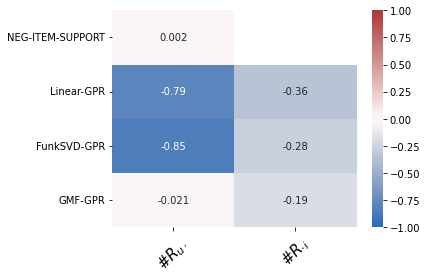

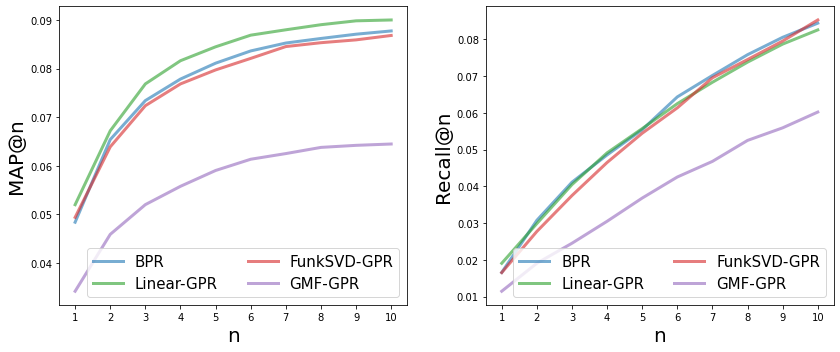

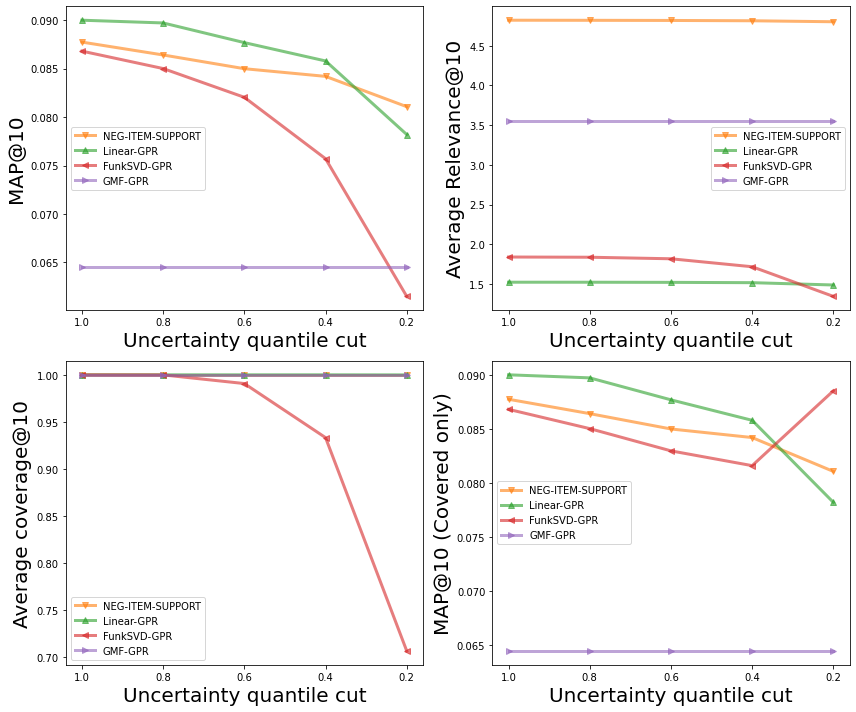

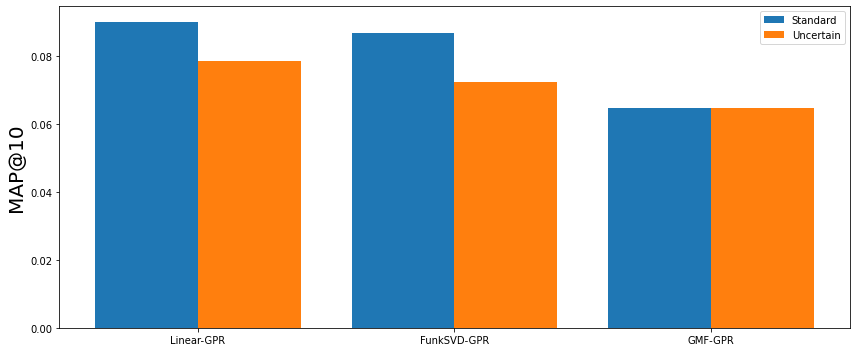

In [7]:
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['BPR', 'NEG-ITEM-SUPPORT', 'Linear-GPR', 'FunkSVD-GPR', 'GMF-GPR']
results = dict((key, results[key]) for key in order)
colors = [c for c in list(TABLEAU_COLORS)]
colors = {k:c for k, c in zip(results, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Rating prediction evaluation
ratings = pd.DataFrame([results[key] for key in results], index=results.keys())[['FCP', 'Concordant uncertainty', 'Discordant uncertainty']]
ratings['Ratio'] = ratings['Discordant uncertainty'] / ratings['Concordant uncertainty']
print(ratings)

# URI and UAC
keys = [key for key in results if key != 'BPR']
a = pd.DataFrame([results[key]['Rating_rec'] for key in keys], index=keys)[['URI', 'Unc_MAP_corr']]
print(a)

# Correlation plot
corr = np.empty((len(results)-1, 2))
keys = [key for key in results if key != 'BPR']
for idx, key in enumerate(keys):
    corr[idx, 0] = results[key]['corr_usup']
    corr[idx, 1] = results[key]['corr_isup']
corr = pd.DataFrame(corr, index=keys, columns=[r'#$R_{u\cdot}$', r'#$R_{\cdot i}$'])
corr.loc['NEG-ITEM-SUPPORT', r'#$R_{\cdot i}$'] = np.nan
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

# Top-K accuracy metrics
keys = [key for key in results if key != 'NEG-ITEM-SUPPORT' and key != 'ENSEMBLE' and key != 'RESAMPLE']
f, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['Rating_rec']['MAP'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['Rating_rec']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

# Cuts
keys = [key for key in results if key != 'BPR']
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
for key in keys:
    ax[0, 0].plot(results[key]['Cuts']['MAP'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[0, 1].plot(results[key]['Cuts']['Relevance'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1, 0].plot(results[key]['Cuts']['Coverage'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1, 1].plot(results[key]['Cuts']['Map*'], lines[key], color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0, 0].set_xticks(range(5))
ax[0, 0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0, 0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0, 0].set_ylabel('MAP@10', fontsize=20)
ax[0, 0].legend()
ax[0, 1].set_xticks(range(5))
ax[0, 1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0, 1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0, 1].set_ylabel('Average Relevance@10', fontsize=20)
ax[0, 1].legend()
ax[1, 1].set_xticks(range(5))
ax[1, 1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1, 1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1, 1].set_ylabel('MAP@10 (Covered only)', fontsize=20)
ax[1, 1].legend()
ax[1, 0].set_xticks(range(5))
ax[1, 0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1, 0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1, 0].set_ylabel('Average coverage@10', fontsize=20)
ax[1, 0].legend()
f.tight_layout()
f.savefig('plots/cuts.pdf')

# Rating prediction evaluation
keys = [key for key in keys if key != 'RESAMPLE' and key != 'NEG-ITEM-SUPPORT']
a = {metric: {key: [results[key]['Rating_rec'][metric][-1]] + [results[key]['Uncertain_rec'][metric][-1]] 
              for key in keys} for metric in ['MAP', 'Recall']}
precision = pd.DataFrame(a['MAP'], index=['Standard', 'Uncertain']).T
f, ax = plt.subplots(figsize=(12, 5))
ax.bar(np.arange(len(keys))-0.2, precision['Standard'], 0.4, label='Standard')
ax.bar(np.arange(len(keys))+0.2, precision['Uncertain'], 0.4, label='Uncertain')
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(list(precision.index))
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('plots/unc_rank.pdf')